In [ ]:
import os
checkpoint_id = "38c4a562-1c7f-4659-aea0-18799613d25d"
os.chdir(f"/home/christoph/Code/det-gan-research/checkpoints/{checkpoint_id}/code/")

In [2]:
import cv2
import math
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import scipy.ndimage
import numpy as np
import seaborn as sns
import utils

from ipywidgets import Video
from tqdm.notebook import tqdm
from determined.experimental import Checkpoint
from models import MsgGenerator
from msg_gan import MsgGANTrail

from distributions import TruncatedNormal

In [3]:
trail = Checkpoint.load_from_path("../", map_location=torch.device('cpu'))

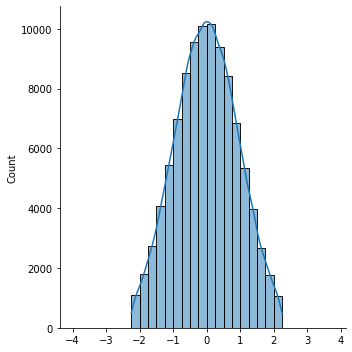

In [4]:
num_images = 6
truncations=(-2.25, 2.25)
noise_size = trail.latent_dimension
z = utils.sample_noise(num_images, noise_size, normalize=False, truncations=truncations)
dist = utils.sample_noise(1, 100000, normalize=False, truncations=truncations).squeeze()

ax = sns.displot(dist, bins=np.arange(-4, 4, 0.25), kde=True)
plt.show()

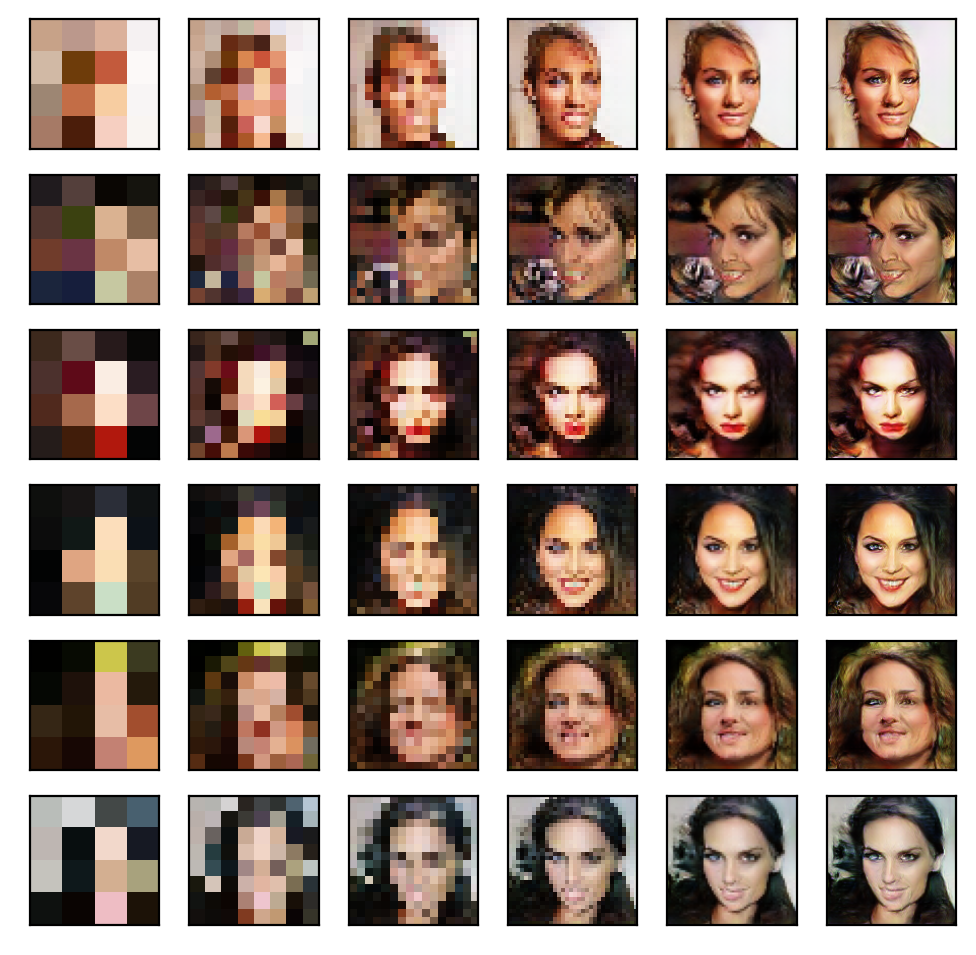

In [5]:
images, w = trail.generator(z)
biggest_size = images[-1].shape[-1]
num_resolutions = int(math.log2(biggest_size))

resolutions, x = trail.generator(z)
fig, axes = plt.subplots(nrows=num_images, ncols=num_resolutions - 1, dpi=200, figsize=(6, 6))

def adjust_dynamic_range(data, drange_in=(-1, 1), drange_out=(0, 1)):
    """
    adjust the dynamic colour range of the given input data
    :param data: input image data
    :param drange_in: original range of input
    :param drange_out: required range of output
    :return: img => colour range adjusted images
    """
    if drange_in != drange_out:
        scale = (np.float32(drange_out[1]) - np.float32(drange_out[0])) \
                / (np.float32(drange_in[1]) - np.float32(drange_in[0]))

        bias = (np.float32(drange_out[0]) - np.float32(drange_in[0]) * scale)
        data = data * scale + bias
        
    return torch.clamp(data, min=0, max=1)



for col, resolution in enumerate(resolutions):
    for row, tensor in enumerate(resolution):
        tensor = utils.shift_image_range(tensor)
        
        image = transforms.ToPILImage()(tensor.cpu())
        axes[row, col].imshow(image)
        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].get_yaxis().set_visible(False)

In [6]:
toPILImage = transforms.ToPILImage()

out_dir = "temp"
os.makedirs(out_dir, exist_ok=True)
video_path = 'temp/interpolation.mp4'


time = 30
fps = 30
smoothing = 1.25
total_frames = time * fps

fourcc = cv2.VideoWriter_fourcc(*'VP90')
video = cv2.VideoWriter(video_path, fourcc=fourcc, fps=fps, frameSize=(biggest_size, biggest_size))

all_z = utils.sample_noise(total_frames, noise_size, normalize=False, truncations=truncations)
all_z = scipy.ndimage.gaussian_filter(all_z, [smoothing * fps, 0])
all_z = torch.from_numpy(all_z)

for idx, z in tqdm(enumerate(all_z), desc="Generating video", total=total_frames):
    frame = idx + 1
    z.unsqueeze_(dim=0)
    tensors, w = trail.generator(z)
    tensor = tensors[-1]
    tensor = adjust_dynamic_range(tensor)
    
    image = toPILImage(tensor.squeeze())
    image = np.array(image)
    image = image[:, :, ::-1].copy() 

    video.write(image)
    
video.release()
Video.from_file(video_path, play=True)

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x1d\x89\x0fmdat\x82…